<a href="https://colab.research.google.com/github/singjack/Spotify-Popularity-Classifier/blob/master/Spotify_ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Song Popularity Classifier**

###The Question/Motivation

We enjoy listening to music and regularly stream music using Spotify. We wanted to be able to predict whether a song is popular or not. **Can we identify whether a song will be classified as 'Popular' or 'Non-Popular' based on certain features?**

###Set-up

We will be making use of several modules to manipulate, visualize, analyze our dataset. These modules are: **Pandas, SKLearn, and MatPlotlib.**



In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import sklearn.datasets

from matplotlib import pyplot as plt
import seaborn as sns
import sklearn
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

###Our data
[Database](https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks)

To help answer our question we are making use of database of 160,000+ Spotify Tracks from 1921-2020. The database makes use of the following features.
**Highlighted features will NOT be used in our model**:
####Primary:
- <mark>id (Id of track generated by Spotify)</mark>

####Numerical:
- acousticness (Ranges from 0 to 1)
- danceability (Ranges from 0 to 1)
- energy (Ranges from 0 to 1)
- <mark>duration_ms (Integer typically ranging from 200k to 300k)</mark>
- instrumentalness (Ranges from 0 to 1)
- valence (Ranges from 0 to 1)
- popularity (Ranges from 0 to 100) ***(*TARGET FEATURE*)***
- tempo (Float typically ranging from 50 to 150)
- liveness (Ranges from 0 to 1)
- loudness (Float typically ranging from -60 to 0)
- speechiness (Ranges from 0 to 1)
- year (Ranges from 1921 to 2020)
####Dummy:
- mode (0 = Minor, 1 = Major)
- explicit (0 = No explicit content, 1 = Explicit content)
####Categorical:
- key (All keys on octave encoded as values ranging from 0 to 11, starting on C as 0, C# as 1 and so on…)
- <mark>artists (List of artists mentioned)</mark>
- <mark>release_date (Date of release mostly in yyyy-mm-dd format, however precision of date may vary)</mark>
- <mark>name (Name of the song)</mark>


In [ ]:
data = pd.read_csv('data.csv', error_bad_lines=False).drop(columns=['artists', 'id', 'release_date', 'name', 'duration_ms'])
# Reading in our data and dropping features to normalize our data

data.info()
data.head(1000)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169909 entries, 0 to 169908
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   acousticness      169909 non-null  float64
 1   danceability      169909 non-null  float64
 2   energy            169909 non-null  float64
 3   explicit          169909 non-null  int64  
 4   instrumentalness  169909 non-null  float64
 5   key               169909 non-null  int64  
 6   liveness          169909 non-null  float64
 7   loudness          169909 non-null  float64
 8   mode              169909 non-null  int64  
 9   popularity        169909 non-null  int64  
 10  speechiness       169909 non-null  float64
 11  tempo             169909 non-null  float64
 12  valence           169909 non-null  float64
 13  year              169909 non-null  int64  
dtypes: float64(9), int64(5)
memory usage: 18.1 MB


,acousticness,danceability,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year
0,0.995,0.708,0.1950,0,0.56300,10,0.1510,-12.428,1,0,0.0506,118.469,0.7790,1928
1,0.994,0.379,0.0135,0,0.90100,8,0.0763,-28.454,1,0,0.0462,83.972,0.0767,1928
2,0.604,0.749,0.2200,0,0.00000,5,0.1190,-19.924,0,0,0.9290,107.177,0.8800,1928
3,0.995,0.781,0.1300,0,0.88700,1,0.1110,-14.734,0,0,0.0926,108.003,0.7200,1928
4,0.990,0.210,0.2040,0,0.90800,11,0.0980,-16.829,1,1,0.0424,62.149,0.0693,1928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.953,0.602,0.4080,0,0.02080,1,0.1240,-8.579,1,0,0.4800,67.748,0.8160,1949
996,0.994,0.805,0.2690,0,0.54600,8,0.1220,-9.150,0,0,0.4870,101.197,0.8350,1949
997,0.945,0.702,0.3200,0,0.00118,5,0.6800,-9.817,1,0,0.3530,75.967,0.4650,1949
998,0.529,0.663,0.1530,0,0.00000,5,0.1940,-29.060,1,0,0.9250,145.585,0.2700,1949


###Visualization of our data

We will first visualize our data to find patterns within it. To do this we will make use of a correlation grid + heatmap and a cluster grid.

First we can visualize our data using a correlation grid that makes use of a heatmap. 

From our correlation grid and heatmap we can see which of the following features appear most frequently together. For our specific inquiry regarding popularity, we can see that the features 'energy', 'loudness', and 'year' give us the highest correlation.

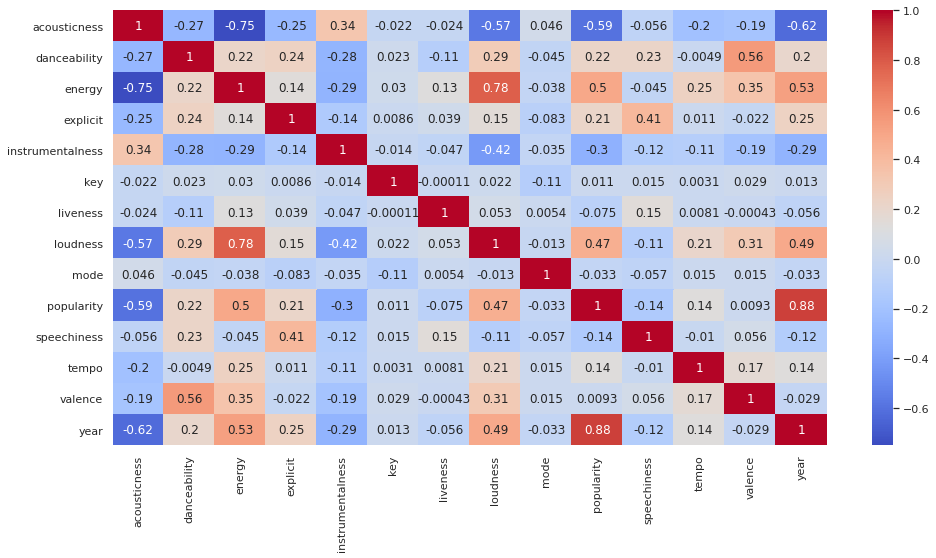

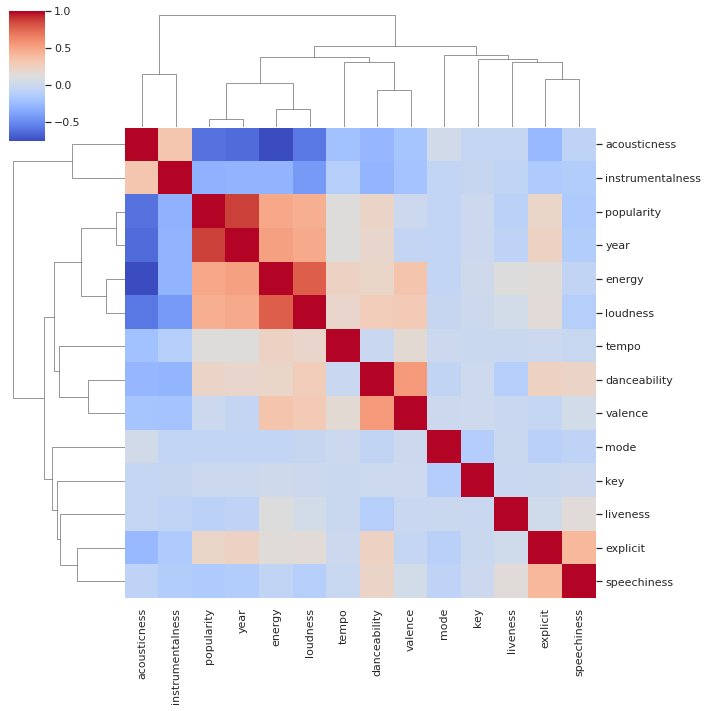

In [ ]:
plt.figure(figsize=(16, 8))
sns.set(style="whitegrid")
corr = data.corr()
# Establishing settings for the following diagrams of our data

sns.heatmap(corr, annot=True,cmap = "coolwarm")
sns.clustermap(corr, cmap="coolwarm")

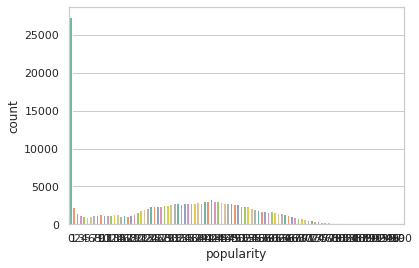

In [ ]:
sns.countplot(x = 'popularity', data = data, palette = 'Set2')

# Viewing the varying levels of popularity of our dataset
# X-Axis: Varying levels of popularity from 0-100
# Y-Axis: Number of Songs

Popularity is initially measured on a scale of 0-100. Thus, we need to convert it to something that is acceptable for a Binary Classification problem. 
<br/>

Initially, we tried doing a 50/50 split down the middle, with everything with a popularity score **below** 50 being Non Popular, and everything **above** 50 being Popular. However, we quickly realized that our data was actually extremely skewed toward the 'Non Popular' class.

In [ ]:
data.mean(axis=0)

#Finding the mean values of our data for the purpose of finding the 'popularity threshold'

acousticness           0.493214
danceability           0.538150
energy                 0.488593
explicit               0.084863
instrumentalness       0.161937
key                    5.200519
liveness               0.206690
loudness             -11.370289
mode                   0.708556
popularity            31.556610
speechiness            0.094058
tempo                116.948017
valence                0.532095
year                1977.223231
dtype: float64

As a solution, we set our Popularity threshold to be the mean of the popularity feature as a method of normalizing this imbalance. We then defined popularity as any song with popularity rating **above** the mean of 31, and non-popular songs being **below** the mean of 31.

#Classifier

Next we set up our data into our x and y variables, with x being our data and the features we will be evaluating, and y being our targeted feature and label for our model.

We chose a 70-30 split for our training/testing data.
- 118,936 songs to **train**
- 50,973 songs to **test**





In [ ]:
dataFeat = ['acousticness', 'danceability', 'energy', 'explicit', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'valence', 'year'] 
# Our features to be used in our model
X, Y = data[dataFeat], data['popularity'] >= 31
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)
# Establish our training and test data
print("Data used to train: ", X_train.shape, Y_train.shape)
print("Data used to test: ", X_test.shape, Y_test.shape)
pd.concat([Y_train.head(10), X_train.head(10)], axis=1)

Data used to train:  (118936, 13) (118936,)
Data used to test:  (50973, 13) (50973,)


,popularity,acousticness,danceability,energy,explicit,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,year
157969,True,0.000446,0.598,0.8310,0,0.024200,1,0.1830,-12.709,1,0.0346,133.084,0.8030,1985
54871,True,0.012900,0.558,0.8640,0,0.055600,11,0.2960,-5.317,1,0.0621,108.019,0.6580,2012
140329,True,0.009640,0.522,0.5200,0,0.000003,7,0.0432,-13.339,1,0.0545,77.757,0.7020,1981
105968,True,0.287000,0.488,0.8550,0,0.000000,7,0.1320,-3.417,1,0.0399,148.971,0.7990,2007
21863,True,0.969000,0.308,0.0631,0,0.193000,2,0.1350,-24.442,0,0.0428,86.717,0.0738,1997
83044,True,0.457000,0.479,0.4160,0,0.000017,4,0.1180,-11.451,0,0.1240,79.593,0.5140,1971
53759,True,0.059700,0.770,0.7240,0,0.000000,1,0.0819,-4.541,1,0.3420,89.673,0.6810,2001
105979,True,0.105000,0.461,0.8330,0,0.004190,11,0.0741,-6.082,0,0.0481,165.635,0.8080,2007
136508,False,0.985000,0.702,0.2210,0,0.711000,11,0.0668,-9.523,0,0.0766,128.359,0.7410,1942
15213,True,0.088200,0.557,0.8560,0,0.032600,7,0.6810,-5.294,1,0.0687,133.527,0.8460,2010


#Train Classifier

Classification methods we used:
- Logistic Regression
- Random Forest

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


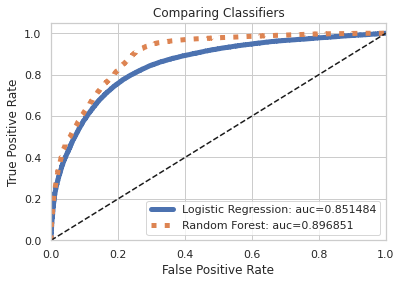

Accuracy:  0.8356777117297393
Precision:  0.8089089531506504


LR Coefficient:  [[-2.66697809e+00  5.09625340e-01  1.90209622e-01  6.37131475e-01
  -4.57134733e-01 -7.09043372e-03 -1.36999895e+00  1.13011644e-01
  -1.26183422e-01 -1.53292576e+00 -1.94326473e-03 -2.15746201e+00
   2.56818262e-03]]
RF_feat:  [0.19385687 0.03032075 0.17142464 0.0361059  0.06040939 0.00252605
 0.00893786 0.09319001 0.00070843 0.03534796 0.01939161 0.00850013
 0.33928039]


In [ ]:
from sklearn import preprocessing
from sklearn import metrics

name = "Logistic Regression"
line_fmt = "-"

model =  LogisticRegression(random_state=10, solver='lbfgs')
model.fit(X_train, Y_train)
# Set up our model to fit it with our data

predictions = model.predict_proba(X_test)
prediction = pd.Series(predictions[:,1])
# Find the prediction probability of our data using our created model

fpr, tpr, thresholds = roc_curve(Y_test, prediction)
auc_score = auc(fpr, tpr)
label='%s: auc=%f' % (name, auc_score)
plt.plot(fpr, tpr, line_fmt, linewidth=5, label=label)

# Calculate our evaluation metrics
# FPR = False Positive Rate
# TPR = True Positive Rate

lr_coef = model.coef_ # added: get coeff for inspection
lr_pred = prediction

name = "Random Forest"
line_fmt = ":"
model =  RandomForestClassifier(random_state=10, max_depth=5, n_estimators=10, max_features=1)
model.fit(X_train, Y_train)
predictions = model.predict_proba(X_test)
prediction = pd.Series(predictions[:,1])
fpr, tpr, thresholds = roc_curve(Y_test, prediction)
auc_score = auc(fpr, tpr)

# Run the same thing for our Random Forest algorithm

label='%s: auc=%f' % (name, auc_score)
plt.plot(fpr, tpr, line_fmt, linewidth=5, label=label)

rf_feat = model.feature_importances_ # added: get coeff for inspection
rf_pred = prediction


plt.legend(loc="lower right")
plt.title('Comparing Classifiers')

plt.plot([0, 1], [0, 1], 'k--') #x=y line.  Visual aid
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()
# Plot our graphs using both algorithms

accuracy = model.score(X_test, Y_test)
print("Accuracy: ", accuracy)
print("Precision: ", metrics.precision_score(Y_test, prediction > 0.5)) #Threshold
print('\n')
print("LR Coefficient: ", lr_coef)
print("RF_feat: ", rf_feat)

# Various Evaluation metrics

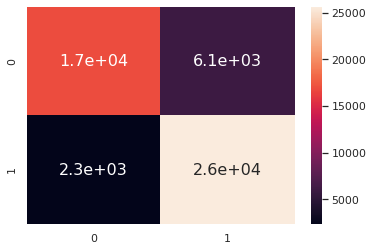

In [ ]:
from sklearn.metrics import confusion_matrix

actual_label = Y_test
predicted_label = (prediction>0.5).astype(int)
cm = metrics.confusion_matrix(actual_label, predicted_label)
sns.heatmap(cm, annot=True, annot_kws = {"size": 16})
# Top Left, Top Right: True Positives, False Positives
# Bottom Left, Bottom RIght: False Negatives, True Negatives


# Can We Make It Better?

### Feature Engineering
- For this section we will be engineering a new feature that we will call 'hype' in order to see whether this will influence our target, popularity. 
- We've defined hype to essentially be a mixture of 3 of the features with the highest correlation values with Popularity: 'energy', 'loudness', 'acousticness'.
<br/>

As a preliminary hypothesis, our guess is that this will greatly help the accuracy of our classifier since, intuitively, 'popular music' does tend to be more loud and energetic. So we are hoping that our results and evaluation will reflect that.

### Feature Selection
In addition to engineering a new feature to help increase the accuracy and precision of our model we will also be omitting "non-important" features through the use of feature importance. 

In [ ]:
featureImportance_col = []
featureImportance = []
# Create two lists to get both the column and a list of the column of the feature

for i,column in enumerate(X):
  print("The feature importance for {} is : {}".format(column, model.feature_importances_[i]))
  featureImportance_col.append(column)
  featureImportance.append(model.feature_importances_[i])
# Iterate over all columns appending the column and it's 'feature importance'
featureImportance_model = zip(featureImportance_col, featureImportance)
featureImportance_model = pd.DataFrame(featureImportance_model, columns = ['Feature','Feature Importance'])

featureImportance_model
# Prints out our inital unsorted feature importance values

featureImportance_model.sort_values('Feature Importance', ascending = False).reset_index()
# Sorted feature importance values

The feature importance for acousticness is : 0.19385687256631212
The feature importance for danceability is : 0.03032075259592689
The feature importance for energy is : 0.17142463753177553
The feature importance for explicit is : 0.036105900086102365
The feature importance for instrumentalness is : 0.0604093936551592
The feature importance for key is : 0.0025260520617877485
The feature importance for liveness is : 0.008937860316915451
The feature importance for loudness is : 0.09319000715326724
The feature importance for mode is : 0.0007084327134635577
The feature importance for speechiness is : 0.03534795866190265
The feature importance for tempo is : 0.01939160847380097
The feature importance for valence is : 0.008500134871735704
The feature importance for year is : 0.33928038931185056


,index,Feature,Feature Importance
0,12,year,0.339280
1,0,acousticness,0.193857
2,2,energy,0.171425
3,7,loudness,0.093190
4,4,instrumentalness,0.060409
5,3,explicit,0.036106
6,9,speechiness,0.035348
7,1,danceability,0.030321
8,10,tempo,0.019392
9,6,liveness,0.008938


From the code above we can see that the features **year, acousticness, energy, loudness, and instrumentalness** hold the most importance in identifying a popular song in our model. In contrast features 7-12 have very little importance to our model and thus we will remove it from our data features set.

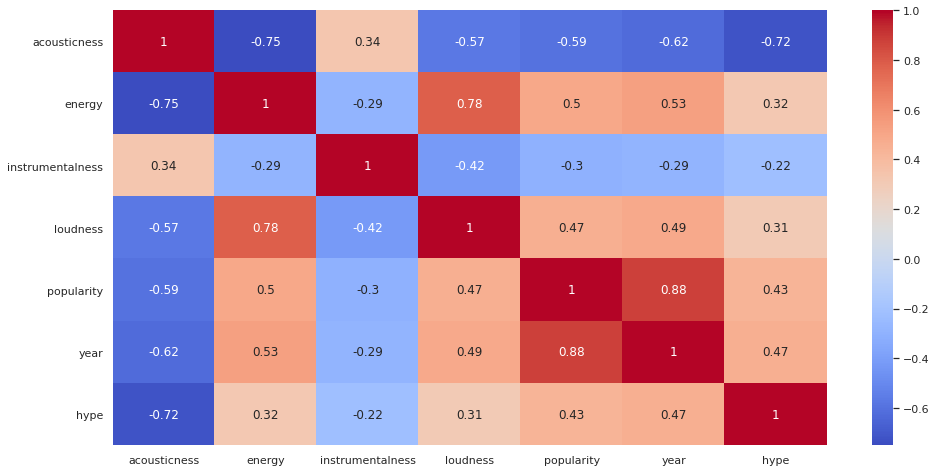

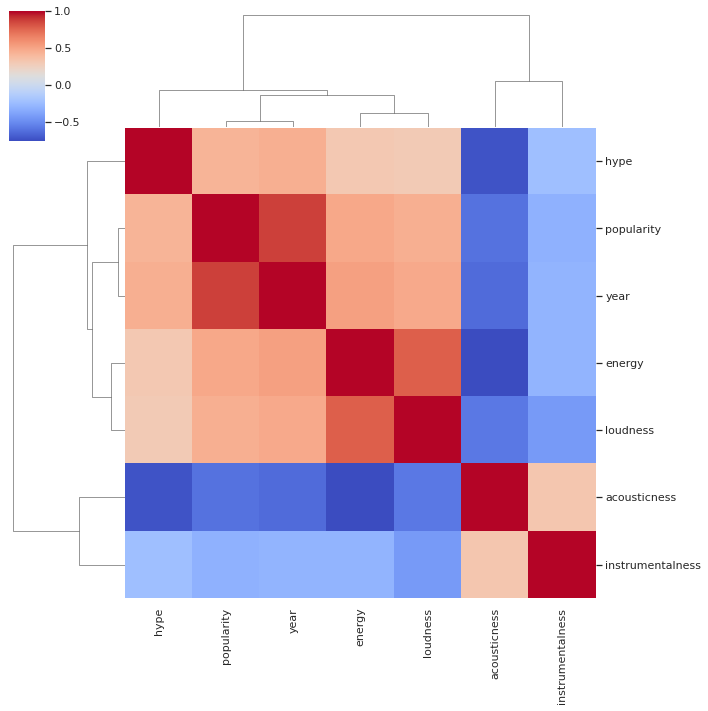

In [ ]:
newData = pd.read_csv('data.csv', error_bad_lines=False).drop(columns=['artists', 'id', 'release_date', 'name', 'duration_ms', 'explicit', 'speechiness', 'tempo', 'danceability', 'liveness', 'valence', 'key', 'mode'])
# Read the data once again for retraining

newData["hype"] = newData["energy"]*newData["loudness"]*newData["acousticness"] # Song's measure of hype = energy * loudness * acousticness
# CREATING NEW FEATURE 'HYPE'

plt.figure(figsize=(16, 8))
sns.set(style="whitegrid")
corr = newData.corr()
sns.heatmap(corr, annot=True,cmap = "coolwarm")
sns.clustermap(corr, cmap="coolwarm")
# Show data with our new restrictions

### Reclassification

Similar to our previous classification, but instead we will only use the most important features provided to us by our previous model including our engineered feature, hype.


In [ ]:
dataFeat = ['acousticness', 'energy', 'instrumentalness', 'loudness', 'year', 'hype']
# Our features to be used in our model
X, Y = newData[dataFeat], newData['popularity'] >= 31
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)
# Establish our training and test data
print("Data used to train: ", X_train.shape, Y_train.shape)
print("Data used to test: ", X_test.shape, Y_test.shape)
pd.concat([Y_train.head(10), X_train.head(10)], axis=1)

Data used to train:  (118936, 6) (118936,)
Data used to test:  (50973, 6) (50973,)


,popularity,acousticness,energy,instrumentalness,loudness,year,hype
54182,True,0.585000,0.6520,0.000012,-8.046,2005,-3.068905
32314,False,0.932000,0.4710,0.023000,-9.757,1930,-4.283050
22377,True,0.000072,0.9720,0.073600,-1.998,2002,-0.000139
96745,True,0.010700,0.8450,0.000000,-5.614,2010,-0.050759
141017,True,0.858000,0.2890,0.846000,-12.859,1987,-3.188543
59597,True,0.198000,0.8190,0.000112,-8.630,1984,-1.399458
62299,True,0.004410,0.8780,0.421000,-7.212,2011,-0.027925
71094,False,0.988000,0.2670,0.827000,-16.294,1951,-4.298292
26749,False,0.291000,0.8840,0.000024,-8.628,1966,-2.219501
128361,False,0.941000,0.0954,0.000000,-11.633,1949,-1.044311


### Retraining

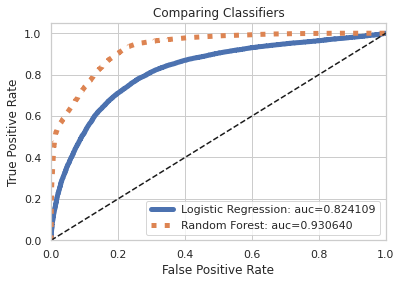

Accuracy:  0.8592195868400918
Precision:  0.8273550327370697


LR Coefficient:  [[-1.75218832e+00  7.18596127e-01 -5.30330115e-01  6.82900694e-02
   1.15172684e-03  2.03979732e-01]]
RF_feat:  [0.12581809 0.10408125 0.02765181 0.15590028 0.48934094 0.09720763]


In [ ]:
name = "Logistic Regression"
line_fmt = "-"

model =  LogisticRegression(random_state=10, solver='lbfgs')
model.fit(X_train, Y_train)
# Set up our model to fit it with our data

predictions = model.predict_proba(X_test)
prediction = pd.Series(predictions[:,1])
# Find the prediction probability of our data using our created model

fpr, tpr, thresholds = roc_curve(Y_test, prediction)
auc_score = auc(fpr, tpr)
label='%s: auc=%f' % (name, auc_score)
plt.plot(fpr, tpr, line_fmt, linewidth=5, label=label)


lr_coef = model.coef_ # added: get coeff for inspection
lr_pred = prediction

name = "Random Forest"
line_fmt = ":"
model =  RandomForestClassifier(random_state=10, max_depth=5, n_estimators=10, max_features=1)
model.fit(X_train, Y_train)
predictions = model.predict_proba(X_test)
prediction = pd.Series(predictions[:,1])
fpr, tpr, thresholds = roc_curve(Y_test, prediction)
auc_score = auc(fpr, tpr)
label='%s: auc=%f' % (name, auc_score)
# Run the same thing for our Random Forest algorithm

plt.plot(fpr, tpr, line_fmt, linewidth=5, label=label)

rf_feat = model.feature_importances_ # added: get coeff for inspection
rf_pred = prediction

plt.legend(loc="lower right")
plt.title('Comparing Classifiers')

plt.plot([0, 1], [0, 1], 'k--') #x=y line.  Visual aid
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()
# Plot our graphs using both algorithms

accuracy = model.score(X_test, Y_test)
print("Accuracy: ", accuracy)
print("Precision: ", metrics.precision_score(Y_test, prediction > 0.5)) #Threshold
print('\n')
print("LR Coefficient: ", lr_coef)
print("RF_feat: ", rf_feat)
# Various Evaluation metrics

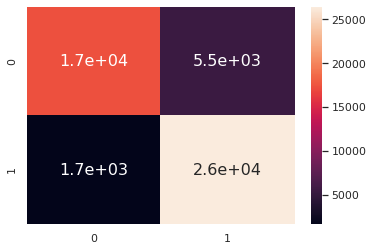

In [ ]:
actual_label = Y_test
predicted_label = (prediction>0.5).astype(int)
cm = metrics.confusion_matrix(actual_label, predicted_label)
sns.heatmap(cm, annot=True, annot_kws = {"size": 16})
# Top Left, Top Right: True Positives, False Positives
# Bottom Left, Bottom RIght: False Negatives, True Negatives

# Conclusion
In conclusion, we can see that based on our analysis of heatmap correlations and the feature engineering, we can deduce that the features such as year,energy, loudness, and acousticness all do indeed postively influence our target feature "popularity".
<br/>
<br/>

This is seen through our retrained classifier making use of our engineered feature, "hype" alongside the most important features selected through feacture selection. This new feature set allowed our classifier to improve and ultimately increased our accuracy from 83.6% to 85.9% and increased our precision from 80.9% to 82.7%. Furthermore, we noticed improvements in our confusion matrix with more favorable values in the 'True Positives' and 'True Negatives'. Overall, this engineered feature proved to improve our overall results of classifying any given popularity of a Spotify track.
<br/>
<br/>

So as a takeaway, how does this translate to the real world?
If a musician were to come along and write a song that he/she wanted to become popular, then it would mean that it is statistically in their best interest to make sure that it is:
- energetic
- loud
- acoustic



#References:
Stack Overflow:
- https://stackoverflow.com/questions/31511997/pandas-dataframe-replace-all-values-in-a-column-based-on-condition

Video Series by Data 360 VP:
- https://www.youtube.com/watch?v=tODN7x3BO_E
- https://www.youtube.com/watch?v=NPdn3YPkg9w
- https://www.youtube.com/watch?v=0HDy6n3UD5M

Notesbooks Referenced:
- Professor LePendu's Notebook:https://colab.research.google.com/drive/1JjWdwfQasSvNi370Y2hB6WDVwCBR0_ao?usp=sharing#scrollTo=n5PVW0Savbjt
- Rutuja's Notebook: https://github.com/rutujagurav/Binary-Classification-Predicting-a-pulsar-star/blob/master/PulsarStar_v1.ipynb
